<a href="https://colab.research.google.com/github/praveenkumarchandaliya/STTP_Program/blob/XAI/STTP_CAM_Implemention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CAM Pytorch**

https://www.youtube.com/watch?v=u8HDS4dFU-0&t=235s

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import urllib.request
from torchvision import transforms  #

In [ ]:
#1
resnet34 = torchvision.models.resnet34(pretrained=True)
model = resnet34

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 79.1MB/s]


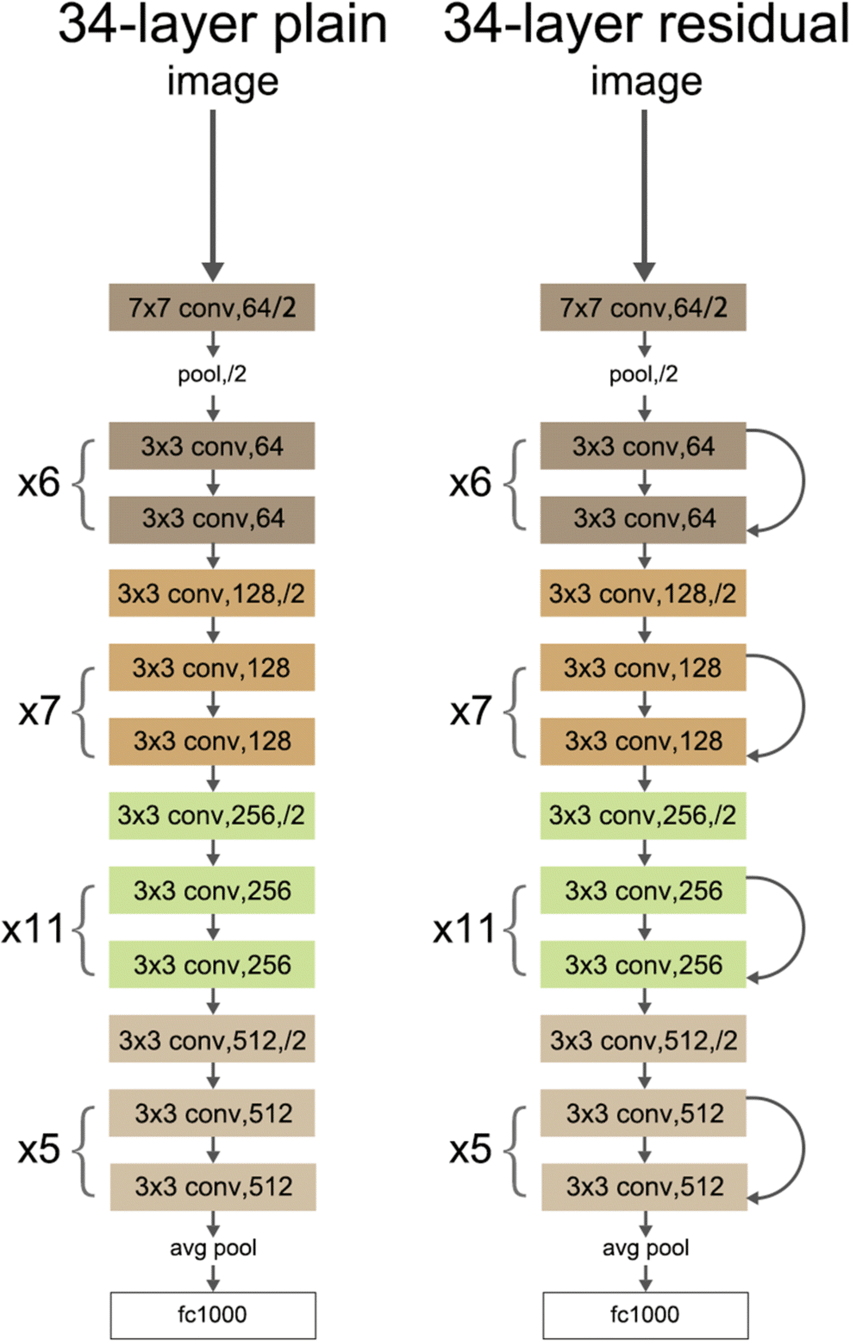

In [ ]:
#2
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
target_url ="https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
classes = []
for line in urllib.request.urlopen(target_url):
  classes.append(line.decode('utf-8'))

In [ ]:
print(model)
# print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

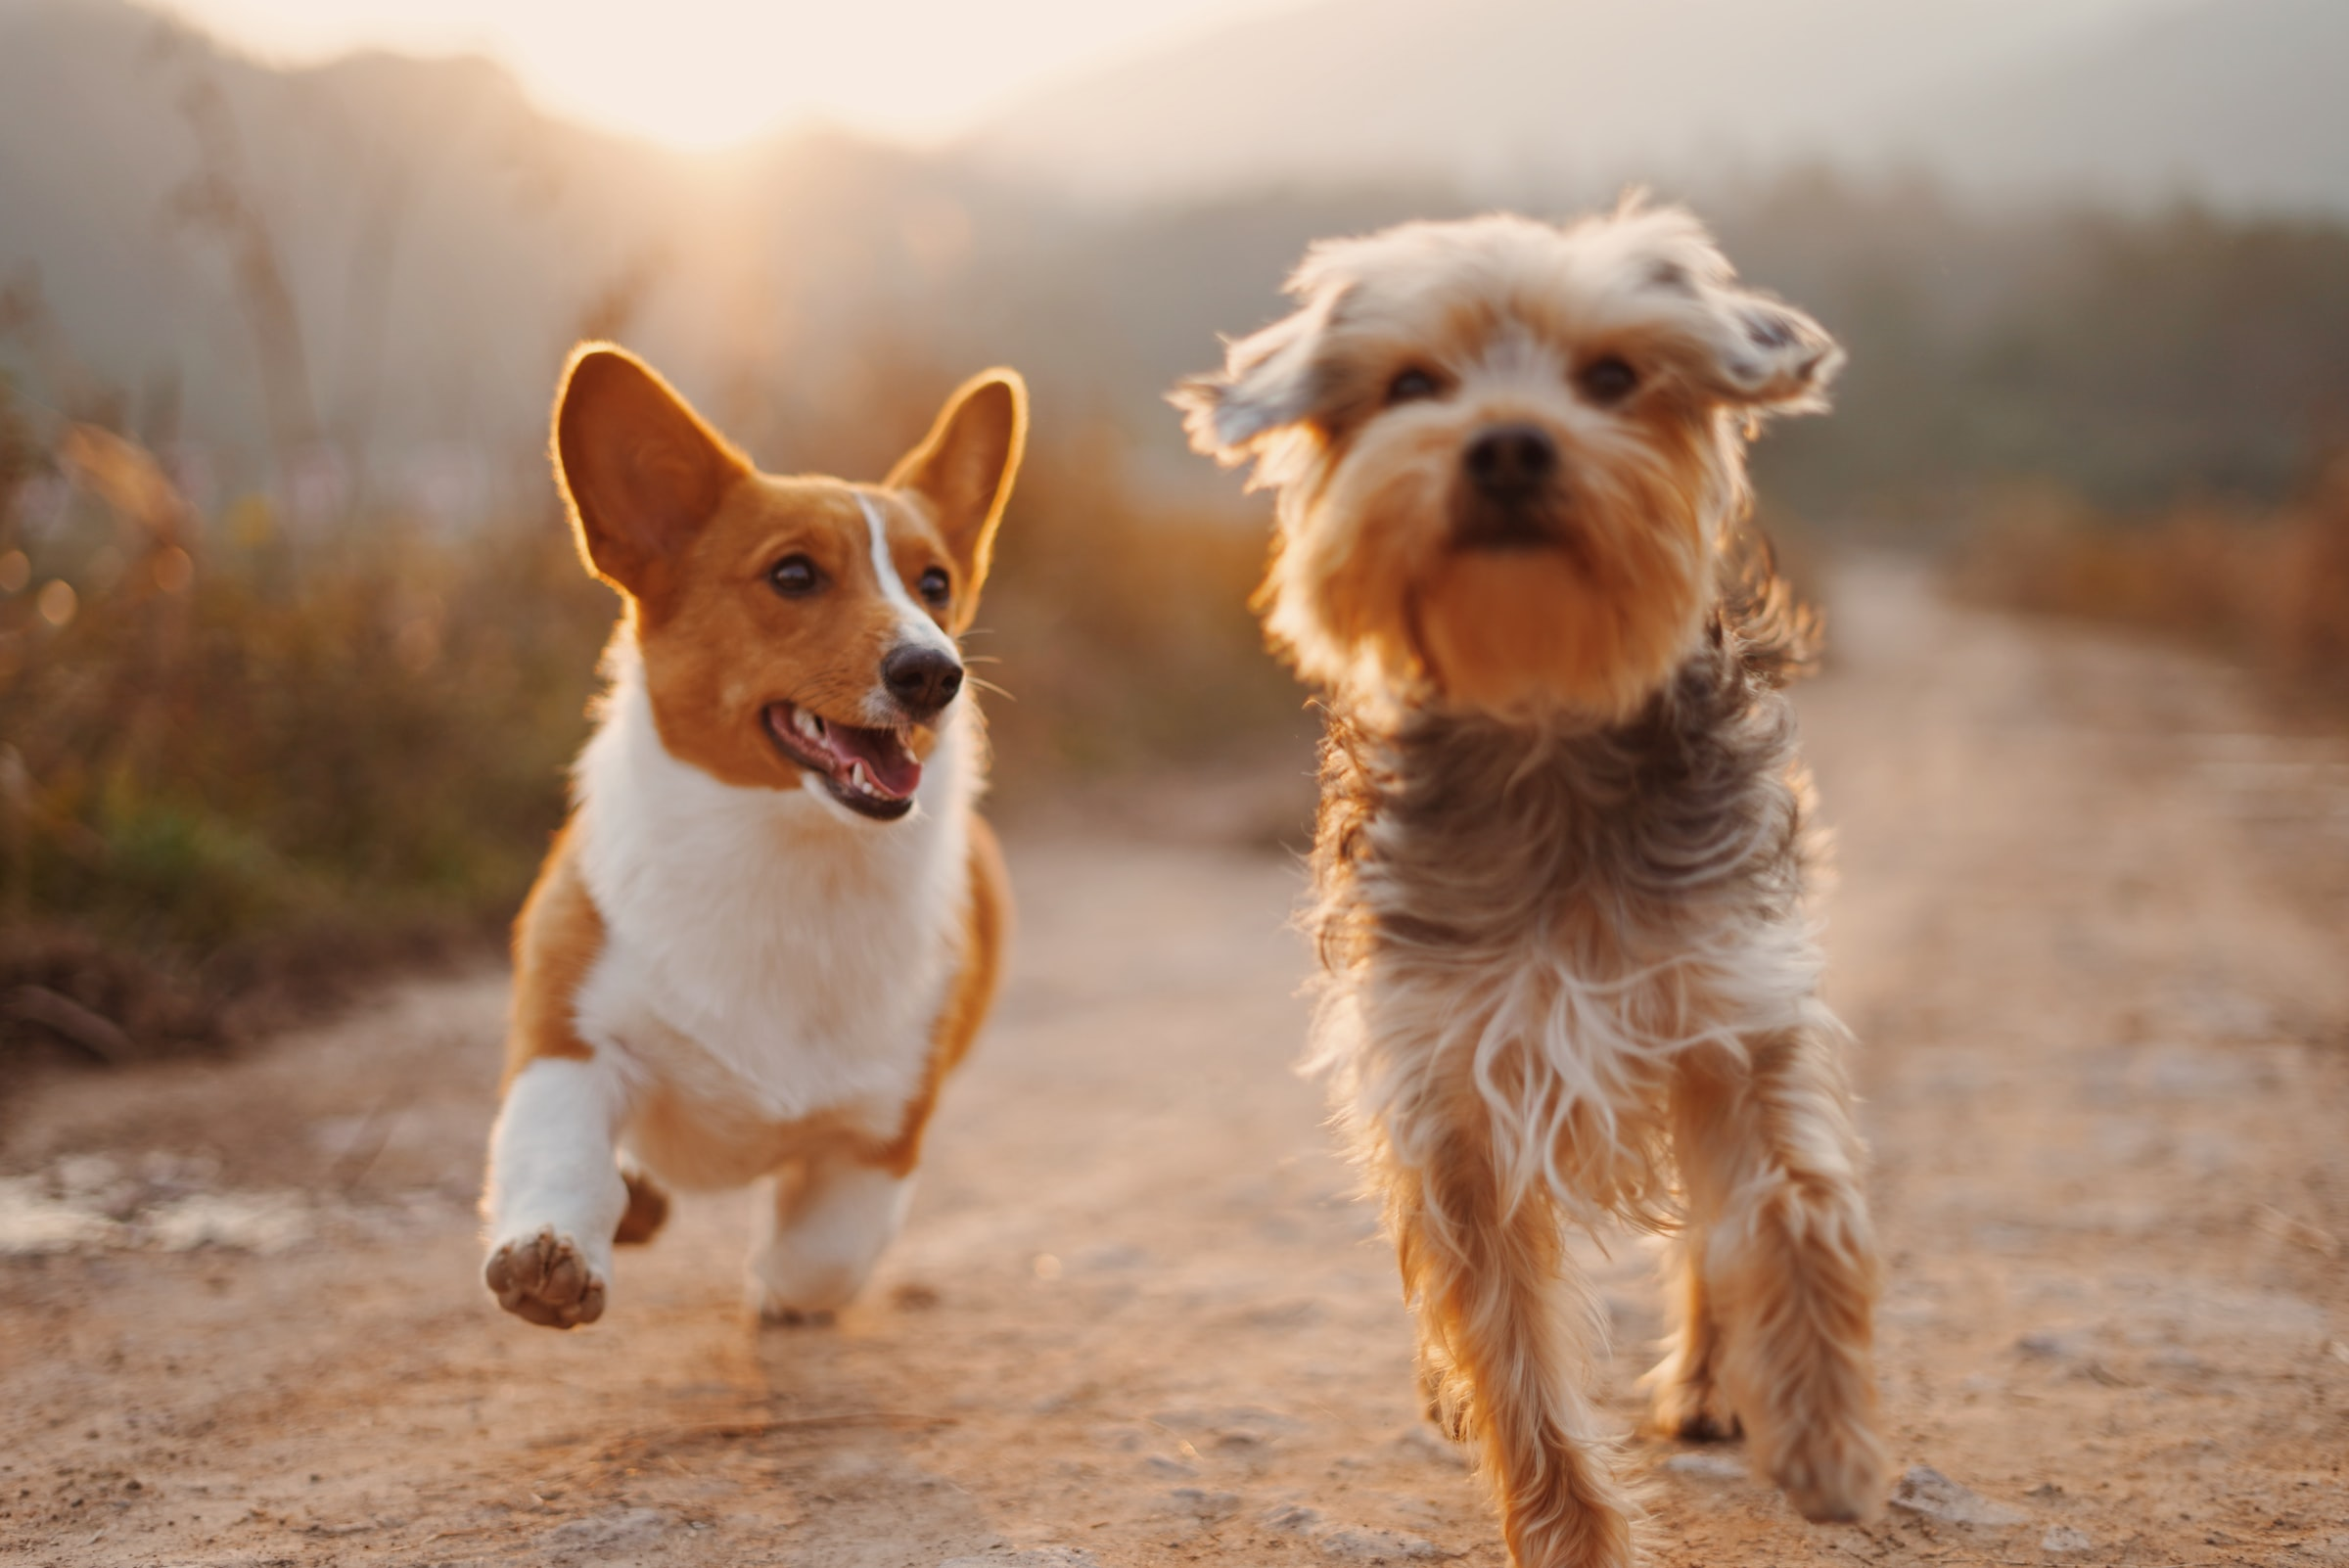

In [ ]:
#4
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(imagenet_mean, imagenet_std),
])

#img = Image.open("/content/drive/MyDrive/STTP/dog1.jpg")  //Corgi  and Yorkhire Terrier
img = Image.open("/content/drive/MyDrive/STTP/dogs.jpg")

img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)
img

In [ ]:
#5
resnet34.eval()
out = resnet34(batch_t)
print(out.shape)
#print the top 5 classes predicted by the model and print the confidential score
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
topk=5
[(classes[idx], idx.data, percentage[idx].item()) for idx in indices[0][:topk]]

torch.Size([1, 1000])


[('meerkat\n', tensor(299), 0.840522050857544),
 ('Yorkshire terrier\n', tensor(187), 0.7021921873092651),
 ('lens cap\n', tensor(622), 0.6744152903556824),
 ('tennis ball\n', tensor(852), 0.6574961543083191),
 ('Blenheim spaniel\n', tensor(156), 0.6479069590568542)]

# Change the last layers of the model

In [ ]:
#6 Paper approach: --- model.fc.weight.data[187].shape
def generate_attention_1(model, img_path, class_index, size=(224, 224)):
    ################################ remove last 2 layers
    newmodel = torch.nn.Sequential(*(list(model.children())[:-2]))
    ################################ Load and preprocess image
    image = PIL.Image.open(img_path)
    image.thumbnail(size, PIL.Image.ANTIALIAS)
    print("Image shape:", image.size)
    batch_t = transform(image)[None]
    ################################ extract weights from the last FC layer corresponding to target class
    m_weights = model.fc.weight.data[class_index]
    print(m_weights.shape) #torch.Size([512])
    ################################ Forward
    fms = newmodel(batch_t)# [1, 512, 7, 7]
    fms = fms.squeeze(0)# [512,7,7]
    out_t = fms * m_weights[:, None, None]
    y_0 = torch.mean(out_t, dim=0) # AVG on channel dim. [512,7,7] --> [7,7]

    ################################ Viz
    plt.figure(figsize=(30, 12))
    ax = plt.subplot(1, 3, 1)
    ax.axis("off")
    plt.imshow(img)

    ax = plt.subplot(1, 3, 2)
    ax.axis("off")
    plt.imshow(y_0.detach().numpy())

    ax = plt.subplot(1, 3, 3)
    ax.axis("off")
    ax.imshow(img)
    ax.imshow(y_0.detach().numpy(), alpha=0.6, interpolation="bilinear", cmap="magma",
              extent=(0,img.size[0],img.size[1],0))

In [ ]:
!pip install Pillow==9.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.0 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.
google-genai 0.3.0 requires pillow<12.0.0,>=10.0.0, but you have pillow 9.5.0 which is incompatible.


<ipython-input-8-3f08c4c17fcd>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image.thumbnail(size, PIL.Image.ANTIALIAS)


Image shape: (1024, 684)
torch.Size([512])


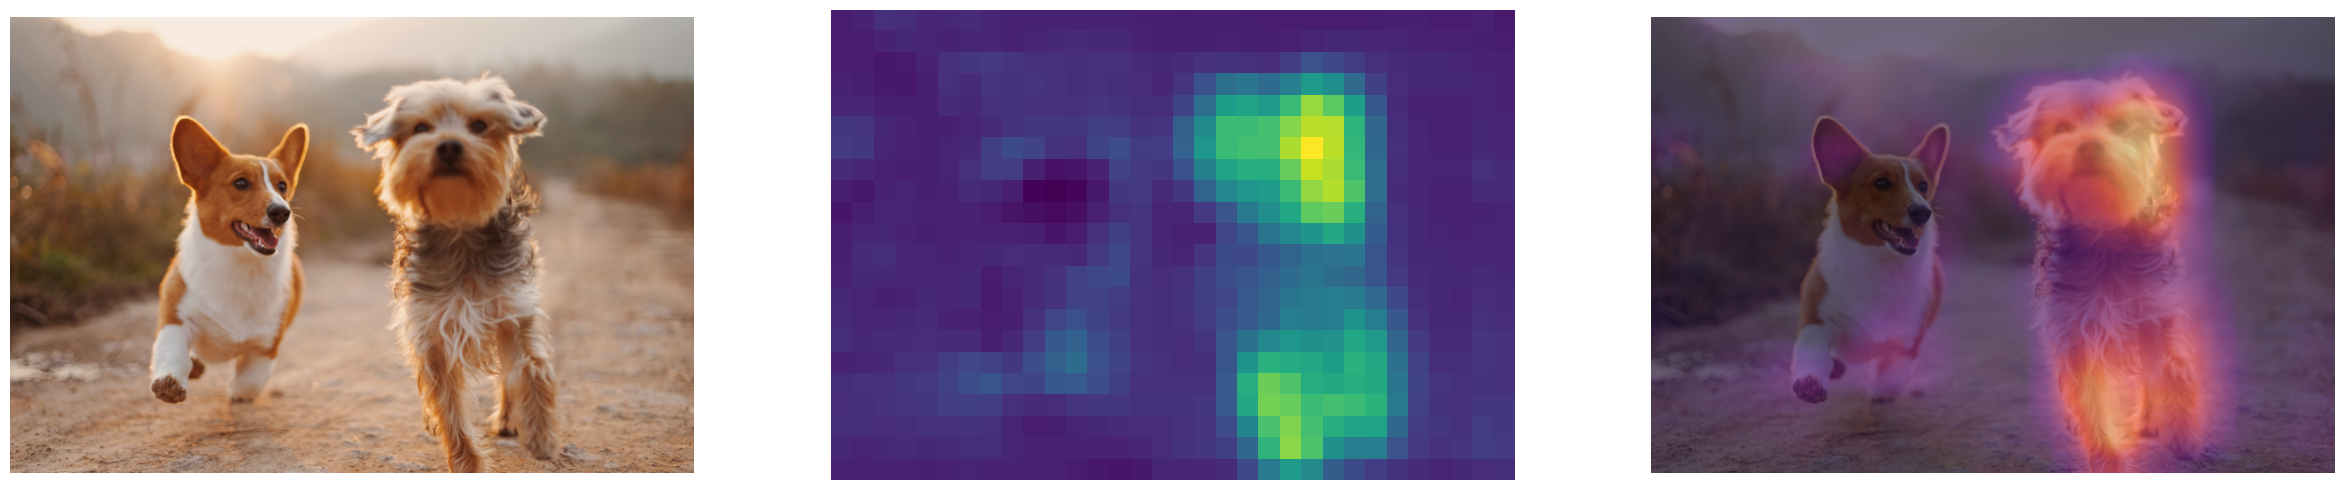

In [ ]:
# 187 is Yorksier
generate_attention_1(model, "/content/drive/MyDrive/STTP/dogs.jpg", 187, size=(1024, 1024))

<ipython-input-8-3f08c4c17fcd>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image.thumbnail(size, PIL.Image.ANTIALIAS)


Image shape: (1024, 684)
torch.Size([512])


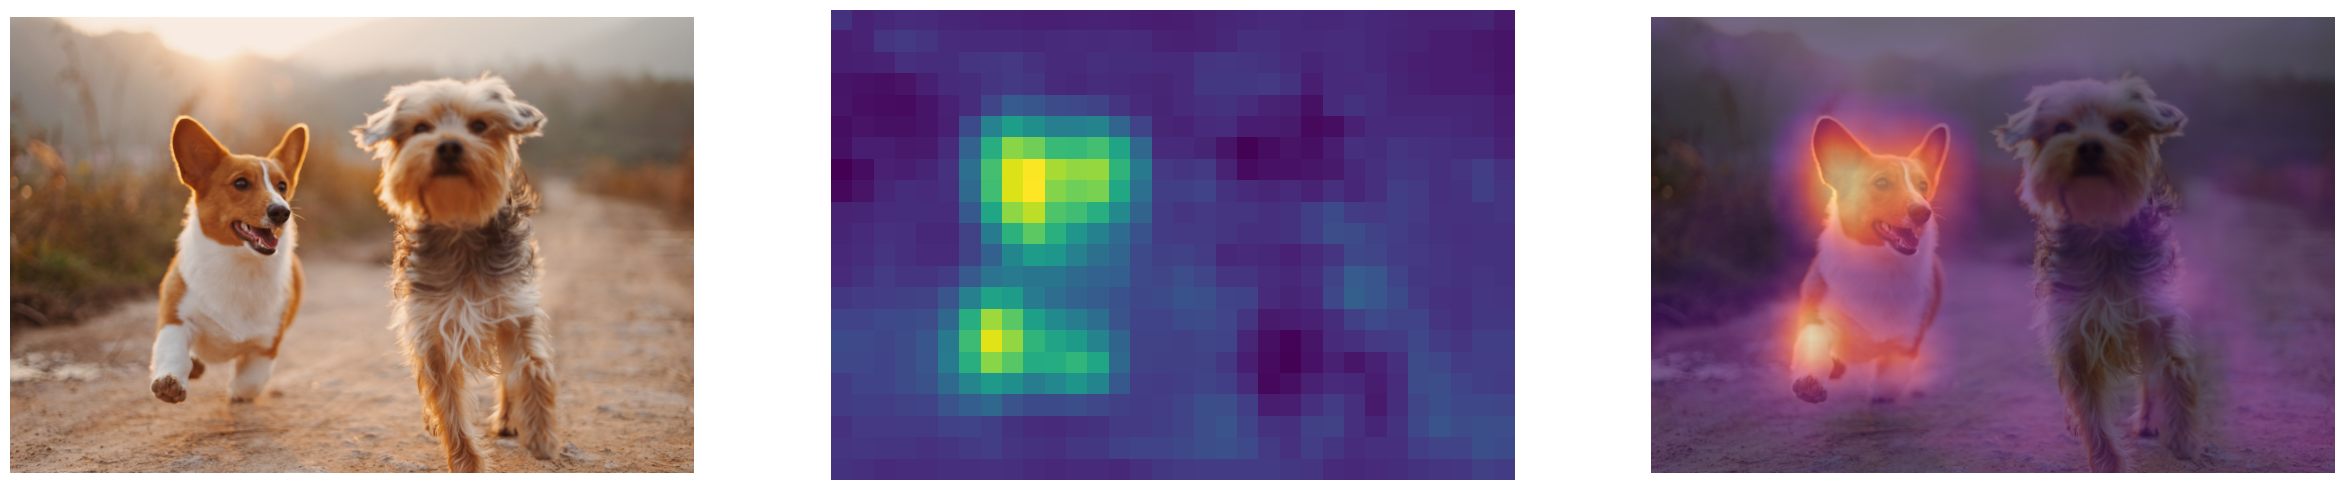

In [ ]:
# See activation for "Corgi" (Class indexes = 263 & 264)
# 263: 'Pembroke, Pembroke Welsh corgi',
# 264: 'Cardigan, Cardigan Welsh corgi',

generate_attention_1(model, "/content/drive/MyDrive/STTP/dogs.jpg", 264, size=(1024, 1024))